In [1]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

In [2]:
%%appyter hide_code

{% do SectionField(
    name='primary',
    title='C2M2 FAIR Assessment',
    subtitle='Assessing c2m2 datapackages for FAIRness',
) %}

{% set file = FileField(
    name='file',
    label='C2M2 Datapackage (.zip)',
    help='Provide your zipped c2m2 datapackage',
    examples={'example.zip': url_for('static', path='example.zip')},
    default='example.zip',
    section='primary',
) %}

# C2M2 Assessment

We assess all files defined in a C2M2 datapackage against the C2M2 Rubric.

In [3]:
import os
import re
import glob
import requests
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
def one_and_only(it):
  it = iter(it)
  ret = next(it)
  try:
    next(it)
    raise Exception('Expected one')
  except StopIteration:
    return ret

def deep_find(root, file):
  return set.union(
    set(glob.glob(os.path.join(root, file))),
    set(glob.glob(os.path.join(root, '**', file))),
  )

def fetch_cache(url, filename, cachedir='.cached'):
  import os, urllib.request
  os.makedirs(cachedir, exist_ok=True)
  if not os.path.exists(os.path.join(cachedir, filename)):
    urllib.request.urlretrieve(url, filename=os.path.join(cachedir, filename))
  return os.path.join(cachedir, filename)

def url_join(*args):
  return '/'.join(arg.rstrip('/') for arg in args)

def filter_empty(val):
  ''' Attempt to catch some actual null values that aren't null
  '''
  return [
    v
    for v in val
    if v is not None and (
      type(v) != str or v.strip().lower() not in {
        '-',
        '-666',
        '',
        'empty',
        'n/a',
        'na',
        'nan',
        'nil',
        'none',
        'not defined',
        'null',
        'undef',
        'undefined',
      }
    )
  ]

## Step 1. Load DERIVA compatible client from URL or datapackage

In [30]:
%%appyter code_exec
import zipfile

file = {{ file }}
directory = os.path.splitext(file)[0]

with zipfile.ZipFile(file, 'r') as z:
    z.extractall(directory)

```python
import zipfile
file = 'example.zip'
directory = os.path.splitext(file)[0]
with zipfile.ZipFile(file, 'r') as z:
    z.extractall(directory)
```

In [6]:
from deriva_compat import create_offline_client
CFDE = create_offline_client(deep_find(directory, 'datapackage.json'))

## Step 2. Load External Ontologies for Validation

In [7]:
from ontology_parsing import OBOOntology, CellosaurusOntology
OBI = OBOOntology.parse(fetch_cache('https://raw.githubusercontent.com/obi-ontology/obi/master/views/obi.obo', 'OBI.obo'))
UBERON = OBOOntology.parse(fetch_cache('http://purl.obolibrary.org/obo/uberon.obo', 'uberon.owl'))
# MONDO = OBOOntology.parse(fetch_cache('http://purl.obolibrary.org/obo/mondo.obo', 'mondo.obo'))
EDAM = OBOOntology.parse(fetch_cache('http://edamontology.org/EDAM.obo', 'EDAM.obo'))
# NCBITaxon = OBOOntology.parse(fetch_cache('http://purl.obolibrary.org/obo/ncbitaxon.obo', 'ncbitaxon.obo'))
Cellosaurus = CellosaurusOntology.parse(fetch_cache('ftp://ftp.expasy.org/databases/cellosaurus/cellosaurus.xml', 'cellosaurus.xml'))

## Step 3. Prepare C2M2 Rubric

In [8]:
metrics = {}
rubric = {
  '@id': 36,
  'name': 'NIH CFDE Interoperability',
  'description': 'This rubric identifies aspects of the metadata models which promote interoperable dataset querying and filtering',
  'metrics': metrics,
}

def _register_metric(schema):
  global metrics
  def wrapper(func):
    metrics[schema['@id']] = dict(schema, func=func)
  setattr(wrapper, '__name__', schema['name'])
  return wrapper

In [9]:
@_register_metric({
  # standardized metadata format (107), machine readable metadata (106)
  # metadata license (117) (c2m2 ?)
  '@id': 106,
  'name': 'Metadata conformance',
  'description': 'The metadata properly conforms with the CFDE perscribed metadata model specification',
  'principle': 'Findable',
})
def _(file, CFDE=None, **kwargs):
  file_query = lambda: CFDE.tables['file'].filter((
    CFDE.tables['file'].id_namespace == file['id_namespace']
  ) & (
    CFDE.tables['file'].local_id == file['local_id']
  ))
  # 25% file completeness
  file_completeness = [len(list(filter_empty(file.values()))) / len(file.keys())]
  # 25% biosample completeness
  biosample_completeness = []
  biosamples = file_query().link(
    CFDE.tables['file_describes_biosample'], on=((
      CFDE.tables['file'].id_namespace == CFDE.tables['file_describes_biosample'].file_id_namespace
    ) & (
      CFDE.tables['file'].local_id == CFDE.tables['file_describes_biosample'].file_local_id
    ))
  ).link(
    CFDE.tables['biosample'], on=((
      CFDE.tables['file_describes_biosample'].biosample_id_namespace == CFDE.tables['biosample'].id_namespace
    ) & (
      CFDE.tables['file_describes_biosample'].biosample_local_id == CFDE.tables['biosample'].local_id
    ))
  ).entities()
  for biosample in biosamples:
    biosample_completeness.append(
      len(list(filter_empty(biosample.values()))) / len(biosample.keys())
    )
  # 25% subject completeness
  subject_completeness = []
  subjects = file_query().link(
    CFDE.tables['file_describes_subject'], on=((
       CFDE.tables['file'].id_namespace == CFDE.tables['file_describes_subject'].file_id_namespace
    ) & (
       CFDE.tables['file'].local_id == CFDE.tables['file_describes_subject'].file_local_id
    ))
  ).link(
    CFDE.tables['subject'], on=((
       CFDE.tables['file_describes_subject'].subject_id_namespace == CFDE.tables['subject'].id_namespace
    ) & (
       CFDE.tables['file_describes_subject'].subject_local_id == CFDE.tables['subject'].local_id
    ))
  ).entities()
  for subject in subjects:
    subject_completeness.append(
      len(list(filter_empty(subject.values()))) / len(subject.keys())
    )
  # 25% project completeness
  project_completeness = {}
  #
  projects = CFDE.tables['project'].filter((
    CFDE.tables['project'].id_namespace == file['project_id_namespace']
  ) & (
    CFDE.tables['project'].local_id == file['project_local_id']
  ))
  project_entities = list(projects.entities())
  #
  while project_entities:
    project = one_and_only(project_entities)
    project_completeness[url_join(project['id_namespace'], project['local_id'])] = len(list(filter_empty(project.values()))) / len(project.keys())
    #
    p1, pip, p2 = CFDE.tables['project'].alias('p1'), CFDE.tables['project_in_project'].alias('pip'), CFDE.tables['project'].alias('p2')
    path = p1.path.filter(((p1.id_namespace == project['id_namespace']) & (p1.local_id == project['local_id'])))
    path = path.link(pip, on=((path.p1.id_namespace == pip.child_project_id_namespace) & (path.p1.local_id == pip.child_project_local_id)))
    path = path.link(p2, on=((path.pip.parent_project_id_namespace == p2.id_namespace) & (path.pip.parent_project_local_id == p2.local_id)))
    projects = path
    project_entities = list(projects.entities())
  #
  file_completeness = (sum(file_completeness) / len(file_completeness)) if file_completeness else 0.
  biosample_completeness = sum(biosample_completeness) / len(biosample_completeness) if biosample_completeness else 0.
  subject_completeness = sum(subject_completeness) / len(subject_completeness) if subject_completeness else 0.
  project_completeness = sum(project_completeness.values()) / len(project_completeness) if project_completeness else 0.
  complete_completeness = sum([
    0.25 * file_completeness,
    0.25 * biosample_completeness,
    0.25 * subject_completeness,
    0.25 * project_completeness,
  ])
  #
  yield {
    'value': complete_completeness,
    'comment': 'Computed based on completeness of file ({:.2f}) and associated biosample ({:.2f}), subject ({:.2f}), and projects ({:.2f})'.format(
      file_completeness,
      biosample_completeness,
      subject_completeness,
      project_completeness,
    )
  }


In [10]:
@_register_metric({
  '@id': 136,
  'name': 'Program name',
  'description': 'Program name is available for querying',
  'principle': 'Findable',
})
def _(file, CFDE=None, **kwargs):
  # the program name is the root project
  #
  projects = CFDE.tables['project'].filter((
    CFDE.tables['project'].id_namespace == file['project_id_namespace']
  ) & (
    CFDE.tables['project'].local_id == file['project_local_id']
  ))
  project_entities = list(projects.entities())
  #
  while project_entities:
    project = one_and_only(project_entities)
    #
    p1, pip, p2 = CFDE.tables['project'].alias('p1'), CFDE.tables['project_in_project'].alias('pip'), CFDE.tables['project'].alias('p2')
    path = p1.path.filter(((p1.id_namespace == project['id_namespace']) & (p1.local_id == project['local_id'])))
    path = path.link(pip, on=((path.p1.id_namespace == pip.child_project_id_namespace) & (path.p1.local_id == pip.child_project_local_id)))
    path = path.link(p2, on=((path.pip.parent_project_id_namespace == p2.id_namespace) & (path.pip.parent_project_local_id == p2.local_id)))
    projects = path
    project_entities = list(projects.entities())
  # at this point 'project' contains the top level project
  if project['abbreviation'] in {'4DN', 'GTEx', 'HMP', 'KidsFirst', 'LINCS', 'Metabolomics', 'MoTrPAC'}:
    yield {
      'value': 1,
      'comment': 'Identified known program {}'.format(project['name'])
    }
  else:
    yield {
      'value': 0.75,
      'comment': 'Identified unknown top level project {}'.format(project['name'])
    }


In [11]:
@_register_metric({
  '@id': 137,
  'name': 'Project name',
  'description': 'Project name is available for querying',
  'principle': 'Findable',
})
def _(file, CFDE=None, **kwargs):
  # the project name is the direct parent project
  if 'project' not in file:
    yield {
      'value': 0,
      'comment': 'No project found'
    }
  else:
    project = one_and_only(
      CFDE.tables['project'].filter((
        CFDE.tables['project'].id_namespace == file['project_id_namespace']
      ) & (
        CFDE.tables['project'].local_id == file['project_local_id']
      )).entities()
    )
    if 'name' in project:
      yield {
        'value': 1,
        'comment': 'Identified project: {}'.format(project['name'])
      }
    else:
      yield {
        'value': 0.5,
        'comment': 'Project identified, but it had no name'
      }


In [12]:
@_register_metric({
  '@id': 27,
  'name': 'PI Contact',
  'description': 'PI Contact is available for dataset',
  'principle': 'Reusable',
})
def _(file, CFDE=None, **kwargs):
  try:
    contact = one_and_only(
      CFDE.tables['primary_dcc_contact'].filter(
        CFDE.tables['primary_dcc_contact'].project_id_namespace == file['id_namespace']
      ).entities()
    )
    if contact.get('contact_email'):
      yield {
        'value': 0.75,
        'comment': 'Contact email found, possibly PI'
      }
    elif contact.get('dcc_url'):
      yield {
        'value': 0.5,
        'comment': 'DCC website available, contact information might be discoverable'
      }
    else:
      yield {
        'value': 0,
        'comment': 'No contact information was located for this file'
      }
  except:
    yield {
      'value': 0,
      'comment': 'No contact information was located for this file'
    }


In [13]:
@_register_metric({
  '@id': 138,
  'name': 'Responsible institution',
  'description': 'The institution that created this dataset is available',
  'principle': 'Findable',
})
def _(file, CFDE=None, **kwargs):
  yield {
    'value': 0,
    'comment': 'No information about the contributing institution is available in the C2M2 Level 1'
  }


In [14]:
@_register_metric({
  # Access protocol (110)
  '@id': 110,
  'name': 'Access protocol',
  'description': 'The protocol for accessing the data is available and described with a URI',
  'principle': 'Accessible',
})
def _(file, CFDE=None, **kwargs):
  yield {
    'value': 0,
    'comment': 'The C2M2 Level 1 does not provide a means of capturing information about file access'
  }


In [15]:
@_register_metric({
  '@id': 139,
  'name': 'Assay',
  'description': 'Assay is present and a proper CFDE-specified ontological term is found in the CFDE-specified ontologies.',
  'principle': 'Interoperable',
})
def _(file, CFDE=None, **kwargs):
  # TODO: check names
  assay = file.get('assay_type')
  if not assay:
    yield {
      'value': 0.0,
      'comment': 'No assay_type found associated with the file',
    }
  elif OBI.get(assay) is not None:
    yield {
      'value': 1,
      'comment': 'Ontological IRI for Assay found in OBI.',
      'url_comment': assay,
    }
  else:
    yield {
      'value': 0.5,
      'comment': 'Assay found but not verified in OBI.',
      'url_comment': assay,
    }


In [16]:
@_register_metric({
  '@id': 140,
  'name': 'Anatomical Part',
  'description': 'An anatomical part is present and the CFDE-specified ontological term is found in the CFDE-specified ontologies',
  'principle': 'Interoperable',
})
def _(file, CFDE=None, **kwargs):
  # TODO: check names
  biosamples = list(CFDE.tables['file_describes_biosample'].filter((
    CFDE.tables['file_describes_biosample'].file_id_namespace == file['id_namespace']
  ) & (
    CFDE.tables['file_describes_biosample'].file_local_id == file['local_id']
  )).link(
    CFDE.tables['biosample'], on=((
      CFDE.tables['file_describes_biosample'].biosample_id_namespace == CFDE.tables['biosample'].id_namespace
    ) & (
      CFDE.tables['file_describes_biosample'].biosample_local_id == CFDE.tables['biosample'].local_id
    ))
  ).entities())
  if len(biosamples) < 1:
    yield {
      'value': 0.0,
      'comment': 'No biosamples found described by the file',
    }
  else:
    for biosample in biosamples:
      anatomy = biosample.get('anatomy')
      if not anatomy:
        yield {
          'value': 0.0,
          'comment': 'No anatomy found on the biosample',
        }
      elif UBERON.get(anatomy) is not None:
        yield {
          'value': 1,
          'comment': 'Ontological IRI for Anatomy found in UBERON.',
          'url_comment': anatomy,
        }
      else:
        yield {
          'value': 0.5,
          'comment': 'Anatomy found but not verified in UBERON.',
          'url_comment': anatomy,
        }


In [17]:
@_register_metric({
  '@id': 141,
  'name': 'Disease',
  'description': 'A disease is present and the CFDE-specified ontological term is found in the CFDE-specified ontologies',
  'principle': 'Interoperable',
})
def _(file, CFDE=None, **kwargs):
  yield {
    'value': 0,
    'comment': 'No information about the disease is available in the C2M2 Level 1'
  }


In [18]:
@_register_metric({
  '@id': 142,
  'name': 'File type',
  'description': 'A file type is present and the CFDE-specified ontological term is found in the CFDE-specified ontologies',
  'principle': 'Interoperable',
})
def _(file, CFDE=None, **kwargs):
  # TODO: check names
  for term_type, term in [('file format', file.get('file_format')), ('data type', file.get('data_type'))]:
    if not term:
      yield {
        'value': 0.0,
        'comment': 'No {} found on the biosample'.format(term_type),
      }
    elif EDAM.get("EDAM_{term}".format(term=term)) is not None:
      yield {
        'value': 1,
        'comment': 'Ontological IRI for {} found in EDAM.'.format(term_type),
        'url_comment': term,
      }
    else:
      yield {
        'value': 0.5,
        'comment': '{} found but not verified in EDAM.'.format(term_type.capitalize()),
        'url_comment': term,
      }


In [19]:
@_register_metric({
  '@id': 143,
  'name': 'Taxonomy',
  'description': 'A taxonomy is present and the CFDE-specified ontological term is found in the CFDE-specified ontologies',
  'principle': 'Interoperable',
})
def _(file, CFDE=None, ncbi_taxon_client=None, **kwargs):
  # TODO: check names
  path = CFDE.tables['file'].filter((CFDE.tables['file'].id_namespace == file['id_namespace']) & (CFDE.tables['file'].local_id == file['local_id']))
  path = path.link(
    CFDE.tables['file_describes_subject'], on=((
      CFDE.tables['file'].id_namespace == CFDE.tables['file_describes_subject'].file_id_namespace
    ) & (
      CFDE.tables['file'].local_id == CFDE.tables['file_describes_subject'].file_local_id
    ))
  )
  path = path.link(
    CFDE.tables['subject'], on=((
      CFDE.tables['file_describes_subject'].subject_id_namespace == CFDE.tables['subject'].id_namespace
    ) & (
      CFDE.tables['file_describes_subject'].subject_local_id == CFDE.tables['subject'].local_id
    ))
  )
  path = path.link(
    CFDE.tables['subject_role_taxonomy'], on=((
      CFDE.tables['subject'].id_namespace == CFDE.tables['subject_role_taxonomy'].subject_id_namespace
    ) & (
      CFDE.tables['subject'].local_id == CFDE.tables['subject_role_taxonomy'].subject_local_id
    ))
  )
  for entity in path.entities():
    if entity.get('taxonomy_id') is None:
      yield {
        'value': 0,
        'comment': 'Taxonomy is not present in subject_role_taxonomy',
      }
    elif entity['taxonomy_id'].startswith('NCBI:txid'):
      taxon = ncbi_taxon_client.fetch(entity['taxonomy_id'][len('NCBI:txid'):])
      if taxon is not None:
        yield {
          'value': 1,
          'comment': 'Taxonomy is present and validated in ncbi',
          'url_comment': entity['taxonomy_id'],
        }
      else:
        yield {
          'value': 0.5,
          'comment': 'Taxonomy is present but not NCBI',
          'url_comment': entity['taxonomy_id'],
        }
    else:
      yield {
        'value': 0.5,
        'comment': 'Taxonomy is present but not NCBI',
        'url_comment': entity['taxonomy_id'],
      }


In [20]:
@_register_metric({
  '@id': 144,
  'name': 'Cell Line',
  'description': 'A cell line is present and the CFDE-specified ontological term is found in the CFDE-specified ontologies',
  'principle': 'Interoperable',
})
def _(file, CFDE=None, **kwargs):
  path = CFDE.tables['file'].filter((CFDE.tables['file'].id_namespace == file['id_namespace']) & (CFDE.tables['file'].local_id == file['local_id']))
  path = path.link(
    CFDE.tables['file_describes_subject'], on=((
      CFDE.tables['file'].id_namespace == CFDE.tables['file_describes_subject'].file_id_namespace
    ) & (
      CFDE.tables['file'].local_id == CFDE.tables['file_describes_subject'].file_local_id
    ))
  )
  path = path.link(
    CFDE.tables['subject'], on=((
      CFDE.tables['file_describes_subject'].subject_id_namespace == CFDE.tables['subject'].id_namespace
    ) & (
      CFDE.tables['file_describes_subject'].subject_local_id == CFDE.tables['subject'].local_id
    ))
  )
  # https://github.com/nih-cfde/specifications-and-documentation/blob/master/draft-C2M2_internal_CFDE_CV_tables/subject_granularity.tsv#L2
  path = path.filter(CFDE.tables['subject'].granularity == 'cfde_subject_granularity:4')
  path = path.subject
  cell_lines = path.entities() # contain all cell line subjects
  for cell_line in cell_lines:
    cellosaurus_cell_line = Cellosaurus.get(cell_line['persistent_id']) if 'persistent_id' in cell_line else None
    if cellosaurus_cell_line and cell_line.get('name') == cellosaurus_cell_line.get('name') and cell_line.get('name') is not None:
      yield {
        'value': 1,
        'comment': 'Ontological IRI for cell line and term match what is found in Cellosaurus.',
        'url_comment': cell_line['persistent_id']
      }
    elif cellosaurus_cell_line is not None:
      yield {
        'value': 0.75,
        'comment': 'Ontological IRI for cell line was found in Cellosaurus.',
        'url_comment': cell_line['persistent_id']
      }
    elif 'name' in cell_line and Cellosaurus.get(cell_line['name']):
      yield {
        'value': 0.75,
        'comment': 'Ontological IRI found in Cellosaurus was in the cell_line name field.',
        'url_comment': cell_line['name'],
      }
    elif 'name' in cell_line:
      yield {
        'value': 0.5,
        'comment': 'Cell line found but not in Cellosaurus',
        'url_comment': cell_line.get('name', ''),
      }
    else:
      yield {
        'value': 0,
        'comment': 'Cell line found but missing any information',
      }


In [21]:
@_register_metric({
  # License (116)
  '@id': 116,
  'name': 'Data Usage License',
  'description': 'A Data usage license is described',
  'principle': 'Reusable',
})
def _(file, CFDE=None, **kwargs):
  yield {
    'value': 0,
    'comment': 'No information about data usage licenses are described in the C2M2 Level 1'
  }


In [22]:
@_register_metric({
  # Persistent identifier (105)
  '@id': 104,
  'name': 'Persistent identifier',
  'description': 'Globally unique, persistent, and valid identifiers (preferrably DOIs) are present for the dataset',
  'principle': 'Findable',
})
def _(file, CFDE=None, **kwargs):
  persistent_id = file.get('persistent_id')
  if persistent_id:
    if re.match(r'^https?://[^/]+\.doi\.org/.+$', persistent_id):
      yield {
        'value': 1,
        'comment': 'A DOI was identified in the persistent_id',
        'url_comment': persistent_id,
      }
    else:
      yield {
        'value': 0.5,
        'comment': 'A persistent_id was identified but it is not a doi',
        'url_comment': persistent_id,
      }
  else:
    yield {
      'value': 0,
      'comment': 'No persistent_id defined'
    }


In [23]:
@_register_metric({
  # Resource identifier (108)
  '@id': 108,
  'name': 'Resource identifier',
  'description': 'An identifier for the resource is present',
  'principle': 'Findable',
})
def _(file, CFDE=None, **kwargs):
  if file.keys() >= {'local_id', 'id_namespace'}:
    yield {
      'value': 1,
      'comment': 'An id and namespace were provided for the resource',
      'url_comment': '{} {}'.format(file['local_id'], file['id_namespace']),
    }
  else:
    yield {
      'value': 0,
      'comment': 'An id and namespace were not present for the resource',
    }


In [24]:
@_register_metric({
  '@id': 145,
  'name': 'Landing Page',
  'description': 'A landing page exists and is accessible for the identifiers',
  'principle': 'Findable',
})
def _(file, CFDE=None, **kwargs):
  persistent_id = file.get('persistent_id')
  if persistent_id:
    if not re.match(r'^https?://', persistent_id):
      persistent_id = 'https://identifiers.org/{}'.format(persistent_id)
    #
    try:
      status_code = requests.head(persistent_id, headers={'User-Agent': None}).status_code
      if status_code >= 200 and status_code < 300:
        yield {
          'value': 1,
          'comment': 'valid and HEAD reports {}'.format(status_code),
          'url_comment': persistent_id,
        }
      elif status_code >= 300 and status_code < 399:
        yield {
          'value': 0.5,
          'comment': 'valid url but HEAD reported {}, status cannot be determined'.format(status_code),
          'url_comment': persistent_id,
        }
      elif status_code >= 400:
        yield {
          'value': 0.25,
          'comment': 'valid url but HEAD reported {}'.format(status_code),
          'url_comment': persistent_id,
        }
    except requests.exceptions.MissingSchema:
      yield {
        'value': 0.25,
        'comment': 'does not seem to be a valid url'.format(persistent_id),
        'url_comment': persistent_id,
      }
  else:
    yield {
      'value': 0,
      'comment': 'A persistent_id was not provided for the resource',
    }


## Step 4. Perform assessment using rubric

In [25]:
from tqdm import tqdm
from ncbi_taxon import create_ncbi_taxon_client
with create_ncbi_taxon_client() as ncbi_taxon_client:
  ctx = dict(CFDE=CFDE, ncbi_taxon_client=ncbi_taxon_client)
  n_files = CFDE.tables['file'].count()
  answers = [
    dict(
      **answer,
      metric=metric['@id'],
      target=url_join(file['id_namespace'], file['local_id']),
    )
    for file in tqdm(
        CFDE.tables['file'].entities(),
        total=n_files,
        miniters=n_files//100,
    )
    for metric in rubric['metrics'].values()
    for answer in metric['func'](file, **ctx)
  ]

  0%|          | 0/422 [00:00<?, ?it/s]

## Step 5. Review results

In [26]:
df_metrics = pd.DataFrame(metrics)
df_metrics

,106,136,137,27,138,110,139,140,141,142,143,144,116,104,108,145
@id,106,136,137,27,138,110,139,140,141,142,143,144,116,104,108,145
name,Metadata conformance,Program name,Project name,PI Contact,Responsible institution,Access protocol,Assay,Anatomical Part,Disease,File type,Taxonomy,Cell Line,Data Usage License,Persistent identifier,Resource identifier,Landing Page
description,The metadata properly conforms with the CFDE p...,Program name is available for querying,Project name is available for querying,PI Contact is available for dataset,The institution that created this dataset is a...,The protocol for accessing the data is availab...,Assay is present and a proper CFDE-specified o...,An anatomical part is present and the CFDE-spe...,A disease is present and the CFDE-specified on...,A file type is present and the CFDE-specified ...,A taxonomy is present and the CFDE-specified o...,A cell line is present and the CFDE-specified ...,A Data usage license is described,"Globally unique, persistent, and valid identif...",An identifier for the resource is present,A landing page exists and is accessible for th...
principle,Findable,Findable,Findable,Reusable,Findable,Accessible,Interoperable,Interoperable,Interoperable,Interoperable,Interoperable,Interoperable,Reusable,Findable,Findable,Findable
func,<function _ at 0x7f49543eac10>,<function _ at 0x7f49543eadc0>,<function _ at 0x7f49543ea550>,<function _ at 0x7f49543ea160>,<function _ at 0x7f497950cc10>,<function _ at 0x7f497950c790>,<function _ at 0x7f497950c430>,<function _ at 0x7f497950c040>,<function _ at 0x7f49a2803c10>,<function _ at 0x7f49a2803820>,<function _ at 0x7f4911641430>,<function _ at 0x7f4911641b80>,<function _ at 0x7f490c61c040>,<function _ at 0x7f490c61c4c0>,<function _ at 0x7f49a4f35ee0>,<function _ at 0x7f49a6799af0>


In [27]:
df_answers = pd.DataFrame(answers)
df_answers

,value,comment,metric,target,url_comment
0,0.50,Computed based on completeness of file (1.00) ...,106,http://www.lincsproject.org/LDS-1505,NaN
1,1.00,Identified known program Library of Integrated...,136,http://www.lincsproject.org/LDS-1505,NaN
2,0.00,No project found,137,http://www.lincsproject.org/LDS-1505,NaN
3,0.75,"Contact email found, possibly PI",27,http://www.lincsproject.org/LDS-1505,NaN
4,0.00,No information about the contributing institut...,138,http://www.lincsproject.org/LDS-1505,NaN
...,...,...,...,...,...
9281,0.00,Cell line found but missing any information,144,http://www.lincsproject.org/LJP008_A375_24H:P24,NaN
9282,0.00,No information about data usage licenses are d...,116,http://www.lincsproject.org/LJP008_A375_24H:P24,NaN
9283,0.00,No persistent_id defined,104,http://www.lincsproject.org/LJP008_A375_24H:P24,NaN
9284,1.00,An id and namespace were provided for the reso...,108,http://www.lincsproject.org/LJP008_A375_24H:P24,LJP008_A375_24H:P24 http://www.lincsproject.org/


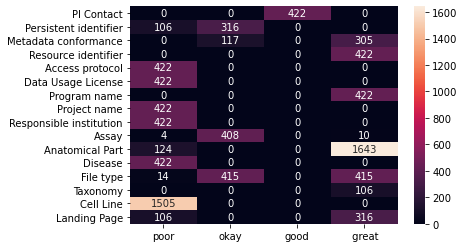

In [28]:
d = df_answers.groupby([
    pd.cut(df_answers['value'], bins=4, labels=('poor', 'okay', 'good', ' great')),
    'metric',
])['value'].count().unstack().T
# replace metric ids with metric names
d.index = df_metrics.loc['name', d.index].values

ax = sns.heatmap(d, fmt='d', annot=True)
for t in ax.get_yticklabels():
  t.set_rotation(0)
ax.set_xlabel('')
plt.show()

In [29]:
comment_vc = df_answers[df_answers['value'] < 1.0]['comment'].value_counts()
comment_vc = comment_vc[comment_vc > 1]
display(comment_vc.head(10))
display(comment_vc.tail(10))

Cell line found but missing any information                                             1505
No information about data usage licenses are described in the C2M2 Level 1               422
The C2M2 Level 1 does not provide a means of capturing information about file access     422
No information about the disease is available in the C2M2 Level 1                        422
No project found                                                                         422
No information about the contributing institution is available in the C2M2 Level 1       422
Contact email found, possibly PI                                                         422
File format found but not verified in EDAM.                                              415
Assay found but not verified in OBI.                                                     408
A persistent_id was identified but it is not a doi                                       316
Name: comment, dtype: int64

Assay found but not verified in OBI.                                                                                  408
A persistent_id was identified but it is not a doi                                                                    316
Computed based on completeness of file (1.00) and associated biosample (0.00), subject (0.00), and projects (1.00)    117
No biosamples found described by the file                                                                             117
No persistent_id defined                                                                                              106
A persistent_id was not provided for the resource                                                                     106
No anatomy found on the biosample                                                                                       7
No file format found on the biosample                                                                                   7
No data type found on th

## Cleanup

No need to run this locally, but useful for appyter.

In [ ]:
import shutil
shutil.rmtree('.cached')
shutil.rmtree(directory)